In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk



In [2]:
df = pd.read_excel(io='AUSCOVID_DATA_2023-04-02_1133.xlsx')

In [3]:
df.head()

record_id redcap_data_access_group  study_site  age  sex  healthcare_worker  \
0         1        royal_north_shore           1   56    2                2.0   
1         2        royal_north_shore           1   33    1                2.0   
2         3        royal_north_shore           1   32    1                2.0   
3         4            ryde_hospital          25   92    2                2.0   
4     133-1        royal_north_shore           1   54    1                2.0   

   nursing_home  past_medical_history  coronary_artery_disease  \
0           2.0                     1                      2.0   
1           2.0                     1                      2.0   
2           2.0                     1                      2.0   
3           1.0                     1                      2.0   
4           2.0                     1                      2.0   

   heart_failure_cardiomyopathy  ...  ecmo  cardiac_arrest  pulm_embolus  \
0                           2.0  ...     2               2           2.0   
1                           2.0  ...     2               2           2.0   
2                           2.0  ...     2               2           2.0   
3                           2.0  ...     2               2           2.0   
4                           2.0  ...     2               2           2.0   

   length_of_stay  admission_date  discharge_date  discharge_status  \
0             2.0             NaT             NaT                 7   
1            24.0             NaT             NaT                 7   
2            21.0             NaT             NaT                 7   
3            32.0             NaT             NaT                 5   
4            11.0             NaT             NaT                 7   

   other_hospital  special_interim_report  \
0             NaN                     2.0   
1             NaN                     2.0   
2             NaN                     2.0   
3             NaN                     2.0   
4             NaN                     2.0   

   australian_cardiovascular_covid19_database_complete  
0                                                  2    
1                                                  2    
2                                                  2    
3                                                  2    
4                                                  2    

[5 rows x 186 columns]

In [175]:
cols = ['age','sex','healthcare_worker','nursing_home','coronary_artery_disease',	
        'heart_failure_cardiomyopathy','af_flutter','severe_valvular_disease','stroke_tia','hypertension',
        'hypercholesterolemia',
       'diabetes', 'pad','smoker','copd','asthma','ckd','dialysis','height','weight','sbp','dbp',
        'heart_rate','respiratory_rate','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','procalcitonin','ferritin','haemoglobin','egfr',
        'creatinine','alt','lactate_venous','chest_xray','vaccinated','pacemaker','hs_troponin_i','hs_troponin_t','troponin_uln']

# ignore abg_timing, 'past_medical_history'
#  'fio2','po2','pco2','lactate_arterial'

df['death'] = [1 if x == 1 or x == 2 else 0 for x in df['discharge_status']]
df['vaccinated'] = [1 if x == 2 or x == 3 or  x == 4 else 0 for x in df['vaccination_status']]
df['pacemaker'] = [1 if x == 1 else 0 for x in df['ppm_icd']]

categorical_col = ['sex','healthcare_worker','nursing_home','coronary_artery_disease',	
        'heart_failure_cardiomyopathy','af_flutter','severe_valvular_disease','stroke_tia','hypertension',
        'hypercholesterolemia','diabetes', 'pad','smoker','copd','asthma','ckd','dialysis',
                   'chest_xray','vaccinated','pacemaker','troponin_uln']



predictor = ['icu_admission_dummy','intubation_dummy','death']
df['icu_admission_dummy'] = [1 if x == 1 else 0 for x in df['icu_admission']]
df['intubation_dummy'] =  [1 if x == 1 else 0 for x in df['intubation']]





df_predictor = df[predictor]
df_reduced = df[cols+predictor]

In [176]:
df_reduced.head()

age  sex  healthcare_worker  nursing_home  coronary_artery_disease  \
0   56    2                2.0           2.0                      2.0   
1   33    1                2.0           2.0                      2.0   
2   32    1                2.0           2.0                      2.0   
3   92    2                2.0           1.0                      2.0   
4   54    1                2.0           2.0                      2.0   

   heart_failure_cardiomyopathy  af_flutter  severe_valvular_disease  \
0                           2.0         2.0                      2.0   
1                           2.0         2.0                      2.0   
2                           2.0         2.0                      2.0   
3                           2.0         2.0                      2.0   
4                           2.0         2.0                      2.0   

   stroke_tia  hypertension  ...  lactate_venous  chest_xray  vaccinated  \
0         2.0           2.0  ...             NaN           3           0   
1         2.0           2.0  ...             0.8           2           0   
2         2.0           2.0  ...             NaN           2           0   
3         1.0           1.0  ...             NaN           2           0   
4         2.0           2.0  ...             2.6           2           0   

   pacemaker  hs_troponin_i  hs_troponin_t  troponin_uln  icu_admission_dummy  \
0          1            NaN            NaN           NaN                    0   
1          1            3.0            NaN           2.0                    1   
2          1            NaN            NaN           NaN                    0   
3          1            NaN            NaN           NaN                    0   
4          1           24.0            NaN           2.0                    1   

   intubation_dummy  death  
0                 0      0  
1                 1      0  
2                 0      0  
3                 0      0  
4                 1      0  

[5 rows x 53 columns]

In [177]:
# only 1714 rows for 49 explanatory variables
df_reduced.shape

(1714, 53)

In [178]:
df_predictor.groupby(predictor).size().unstack(fill_value=0)

death                                    0    1
icu_admission_dummy intubation_dummy           
0                   0                 1278  137
1                   0                  134   17
                    1                  121   27

## Troponin Investigation

In [179]:
troponin_scores = df[['hs_troponin_i','hs_troponin_t','troponin_uln']]
troponin_scores.isnull().sum()

hs_troponin_i    1475
hs_troponin_t    1330
troponin_uln      728
dtype: int64

In [180]:
troponin_scores.isnull().groupby(['hs_troponin_i','hs_troponin_t','troponin_uln']).size().unstack(fill_value=0)

troponin_uln                 False  True
hs_troponin_i hs_troponin_t             
False         False              2     0
              True             236     1
True          False            382     0
              True             366   727

In [181]:
troponin_summary = troponin_scores.isnull().groupby(['hs_troponin_i','hs_troponin_t']).size().unstack(fill_value=0)
total = (troponin_summary.iloc[0,1] + troponin_summary.iloc[1,0])/df_reduced.shape[0]*100
print(total)

36.11435239206535


We have around 600 rows (33\%) with at least a tropinin value...using this may be difficult as a high percentae is missing

In [182]:
troponin_scores['troponin_uln'] = troponin_scores['troponin_uln'].astype(str)

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_19472\1208500490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  troponin_scores['troponin_uln'] = troponin_scores['troponin_uln'].astype(str)


D:\Program Files\anacondav2\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='hs_troponin_t', ylabel='Density'>

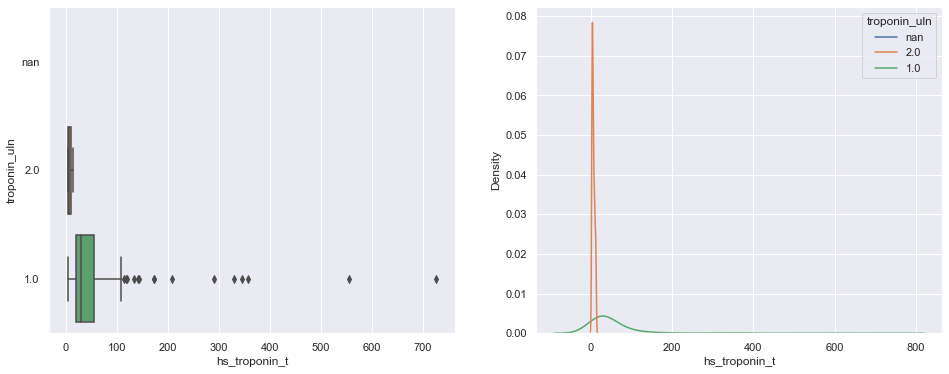

In [183]:
fig, axes = plt.subplots(1, 2,figsize=(16,6))

sns.boxplot(data=troponin_scores, x="hs_troponin_t",y='troponin_uln',ax=axes[0])
sns.kdeplot(data=troponin_scores, x="hs_troponin_t",hue='troponin_uln',ax=axes[1])

D:\Program Files\anacondav2\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='hs_troponin_i', ylabel='Density'>

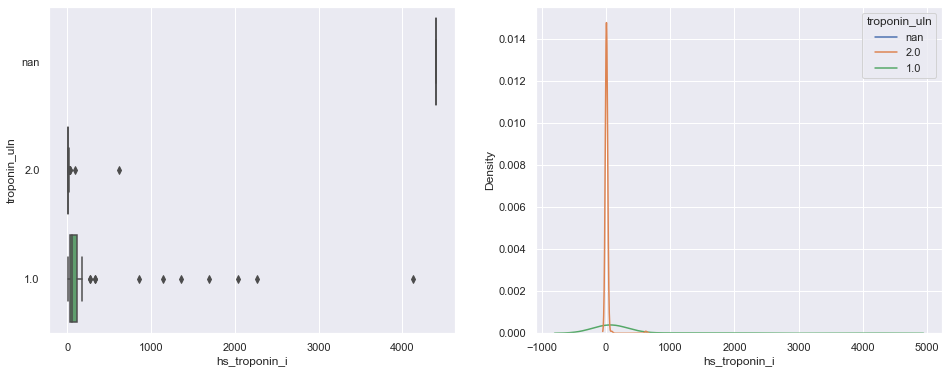

In [184]:
fig, axes = plt.subplots(1, 2,figsize=(16,6))
sns.boxplot(data=troponin_scores, x="hs_troponin_i",y='troponin_uln',ax=axes[0])
sns.kdeplot(data=troponin_scores, x="hs_troponin_i",hue='troponin_uln',ax=axes[1])

In [185]:
troponin_scores.groupby('troponin_uln').describe()

hs_troponin_i                                                   \
                     count         mean         std     min     25%     50%   
troponin_uln                                                                  
1.0                   73.0   248.191781  637.239896     9.0    27.0    49.0   
2.0                  165.0    11.290909   48.438674     1.0     3.0     5.0   
nan                    1.0  4408.000000         NaN  4408.0  4408.0  4408.0   

                             hs_troponin_t                                    \
                 75%     max         count       mean        std  min    25%   
troponin_uln                                                                   
1.0            114.0  4132.0         170.0  55.670588  85.273440  3.0  19.25   
2.0             10.0   620.0         214.0   6.864486   3.125745  3.0   4.00   
nan           4408.0  4408.0           0.0        NaN        NaN  NaN    NaN   

                                 
               50%   75%    max  
troponin_uln                     
1.0           30.0  55.5  727.0  
2.0            6.0   9.0   14.0  
nan            NaN   NaN    NaN

Looking at the indicator of *troponin_uln* (**troponin upper limit normal**), there are some data points that are false negatives, i.e. there are *hs_troponin_i* scores of 620 but have NOT been identified as *troponin_uln*. i.e. the minimum of *hs_troponin_i* of those with *troponin_uln* = 1 is 9 but this coincides with approximately the 70th percentile of *hs_troponin_i* scores with *troponin_uln* = 1.

In [186]:
df['trop_uln_ref'].str.extract('(\d+)').value_counts()

26     52
16     50
14     21
15     10
0       4
20      3
29      3
10      1
252     1
dtype: int64

The troponin upperlimit reference column is not completed particularly well hence it will be difficult to construct a column representing the severity of troponin abnormality.

Overall it seems like using the column *troponin_uln* may be the most suitable column to include.

## Data cleaning

In [187]:
float_col = ['height','sbp','dbp','heart_rate','weight','temperature','fio2','po2',
             'pco2','spo2','crp','lactate_arterial',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','procalcitonin','ferritin','haemoglobin','egfr',
        'creatinine','alt','lactate_venous','hs_troponin_i','hs_troponin_t']
int_col = ['age']

In [188]:
df_reduced['platelets'] = df_reduced['platelets'].str.replace(',', '.')
df_reduced['platelets'] = df_reduced['platelets'].astype(float)

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_19472\1293955339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['platelets'] = df_reduced['platelets'].str.replace(',', '.')
C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_19472\1293955339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['platelets'] = df_reduced['platelets'].astype(float)


In [189]:
df_reduced.dtypes

age                               int64
sex                               int64
healthcare_worker               float64
nursing_home                    float64
coronary_artery_disease         float64
heart_failure_cardiomyopathy    float64
af_flutter                      float64
severe_valvular_disease         float64
stroke_tia                      float64
hypertension                    float64
hypercholesterolemia            float64
diabetes                        float64
pad                             float64
smoker                          float64
copd                            float64
asthma                          float64
ckd                             float64
dialysis                        float64
height                          float64
weight                          float64
sbp                             float64
dbp                             float64
heart_rate                      float64
respiratory_rate                float64
temperature                     float64


In [190]:
df_reduced.isnull().sum().sort_values(ascending=False)

platelets                       1711
hs_troponin_i                   1475
fio2                            1434
lactate_arterial                1392
pco2                            1390
po2                             1389
hs_troponin_t                   1330
procalcitonin                   1322
height                          1100
lactate_venous                   961
ferritin                         930
ldh                              889
weight                           872
d_dimer                          864
troponin_uln                     728
crp                              288
alt                              275
albumin                          219
dbp                              151
spo2                             138
egfr                             134
temperature                      114
asthma                            91
ckd                               90
copd                              90
af_flutter                        90
smoker                            90
s

In [191]:
# drop rows with missing values in these columns for convenience
df_reduced = df_reduced[df_reduced['nursing_home'].notna()]
df_reduced = df_reduced[df_reduced['healthcare_worker'].notna()]

In [192]:
# drop because it is missing
df_reduced = df_reduced.drop('platelets',axis=1)
float_col.remove('platelets')

df_reduced_dummy['weight_new'] = df_reduced_dummy['weight'].replace('\(|[a-zA-Z]+', '', regex=True)
df_reduced_dummy.groupby('weight_new').count()

# Exploration

Several columns have potential outliers and odd values. These columns are:
- height < 120
- temperature >60
- po2 > 200
- pco2 >80
- sp02 < 40
- lactate_arterial > 18
- lymphocutes > 40
- total_wcc > 50
- albumin > 100
- d_dimer > 50
- procalcitonin > 60
- egfr > 700
- lactate_venous > 200

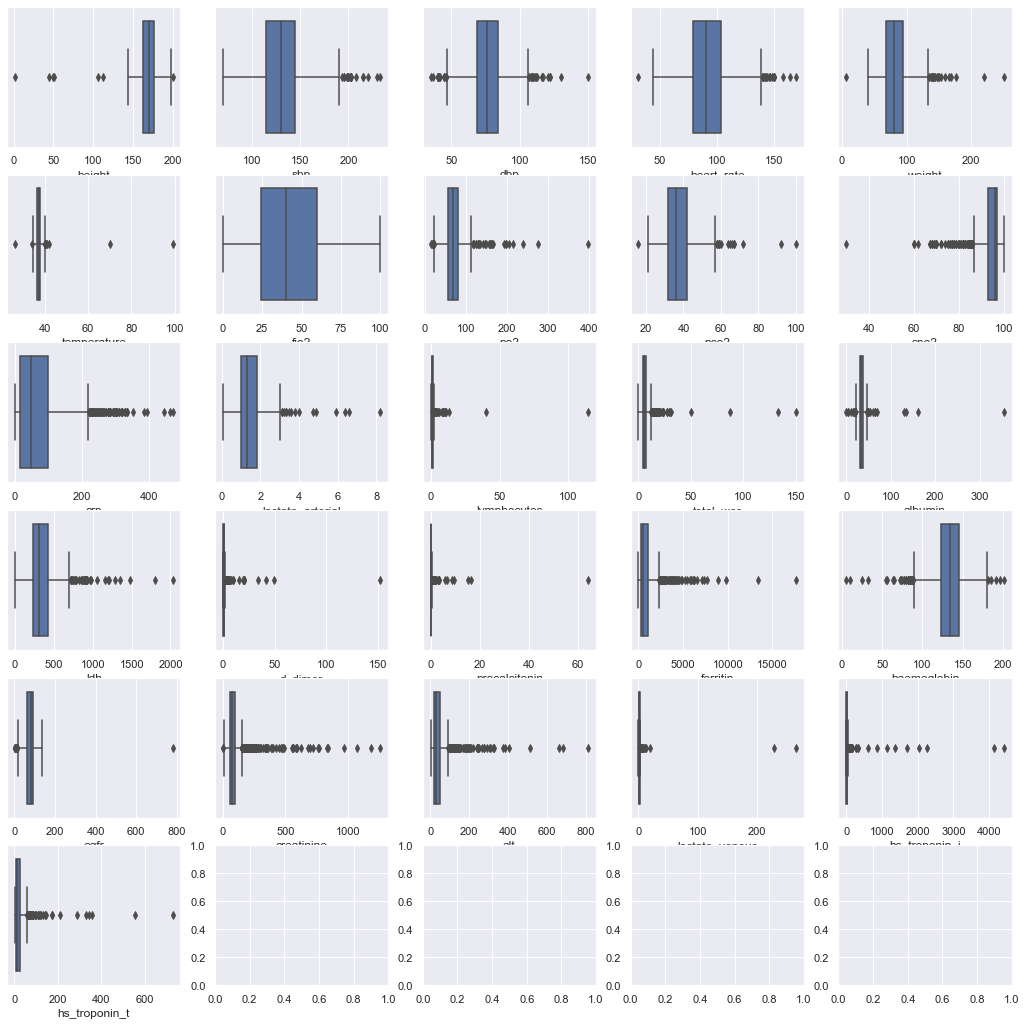

In [126]:
fig, axes = plt.subplots(6, 5, figsize=(18, 18))
i = 0
for c in float_col:
    sns.boxplot(ax=axes[int(i/5), i%5], data=df_reduced, x=c)
    i+=1

## List of Potential Outliers

The univariate logistic regression plots do not suggest there is much explanatory power to death in hospital. It seems like a lot of the explantory power come from outliers of certain variables e.g.
- height
- weight
- temperature
- po2
- pco2
- spo2
- lactate arterial
- lymphocytes
- total_wcc
- albumin
- d_dimer
- procalcitonin
- lactate_venous

There are some variables that could be significant such as
- dbp
- heart_rate
- fio2
- crp
- ldh
- ferritin
- haemoglobin
- creatinine
- albumin

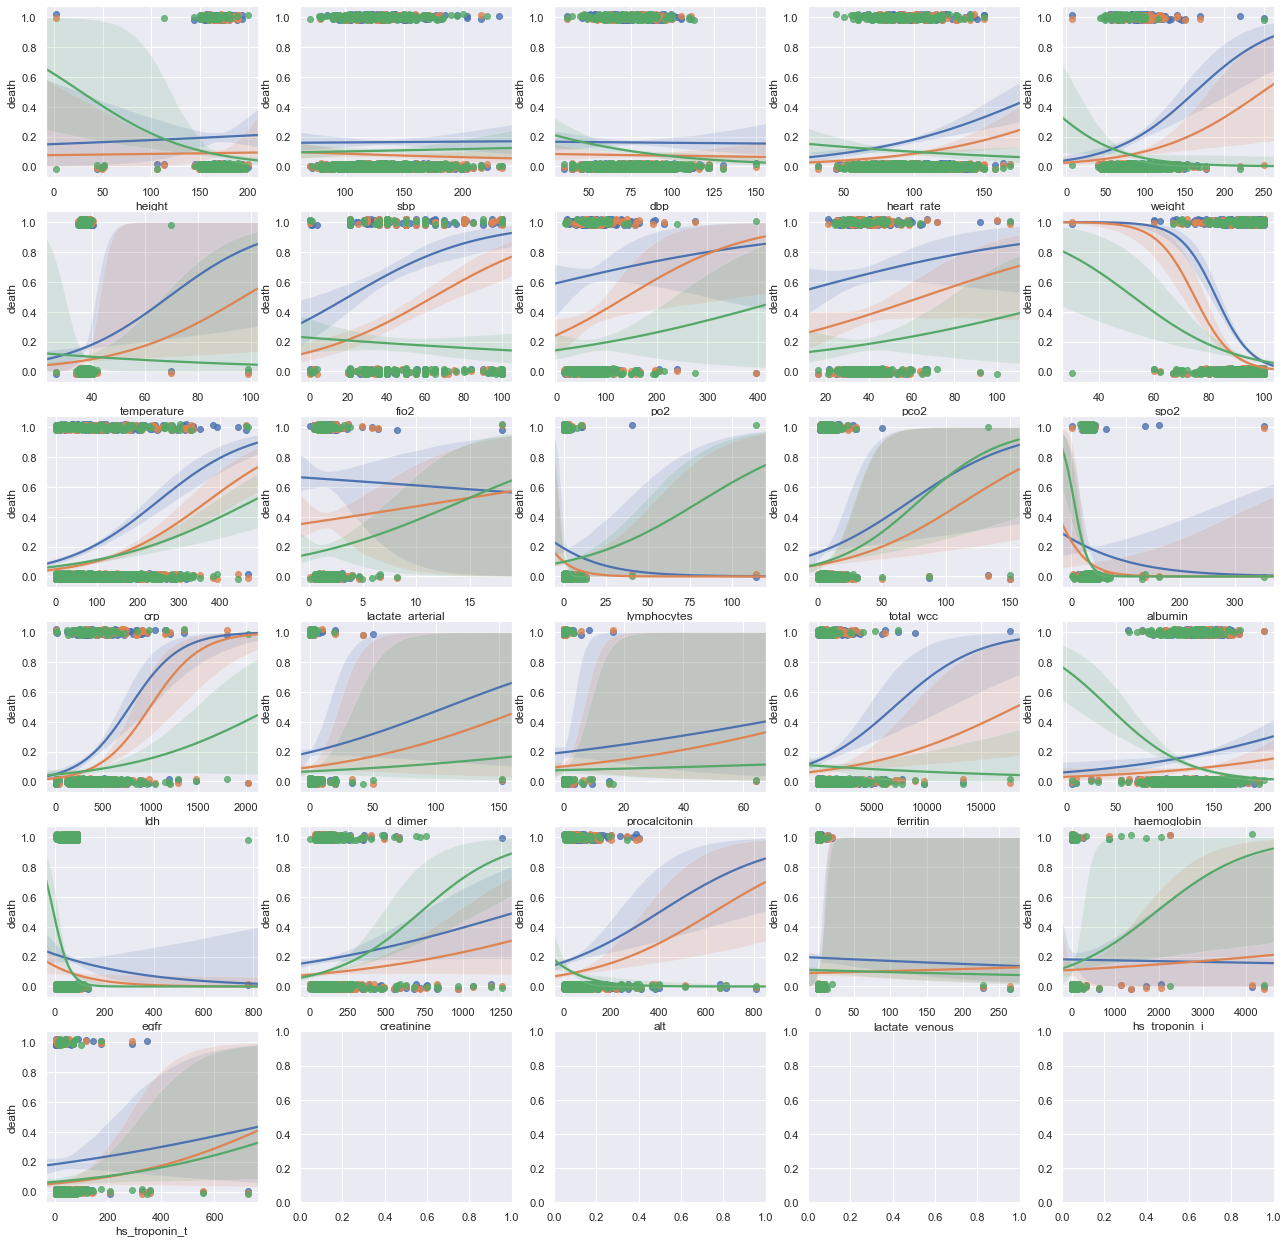

In [158]:
# blue icu admission
# orange intubation
# green death
fig, axes = plt.subplots(6, 5, figsize=(22, 22))
i = 0
for c in float_col:
    for p in predictor:
        sns.regplot(x=c, y=p, data=df_reduced,y_jitter=.02, 
                   logistic=True, truncate=False,ax=axes[int(i/5), i%5])
    i+=1

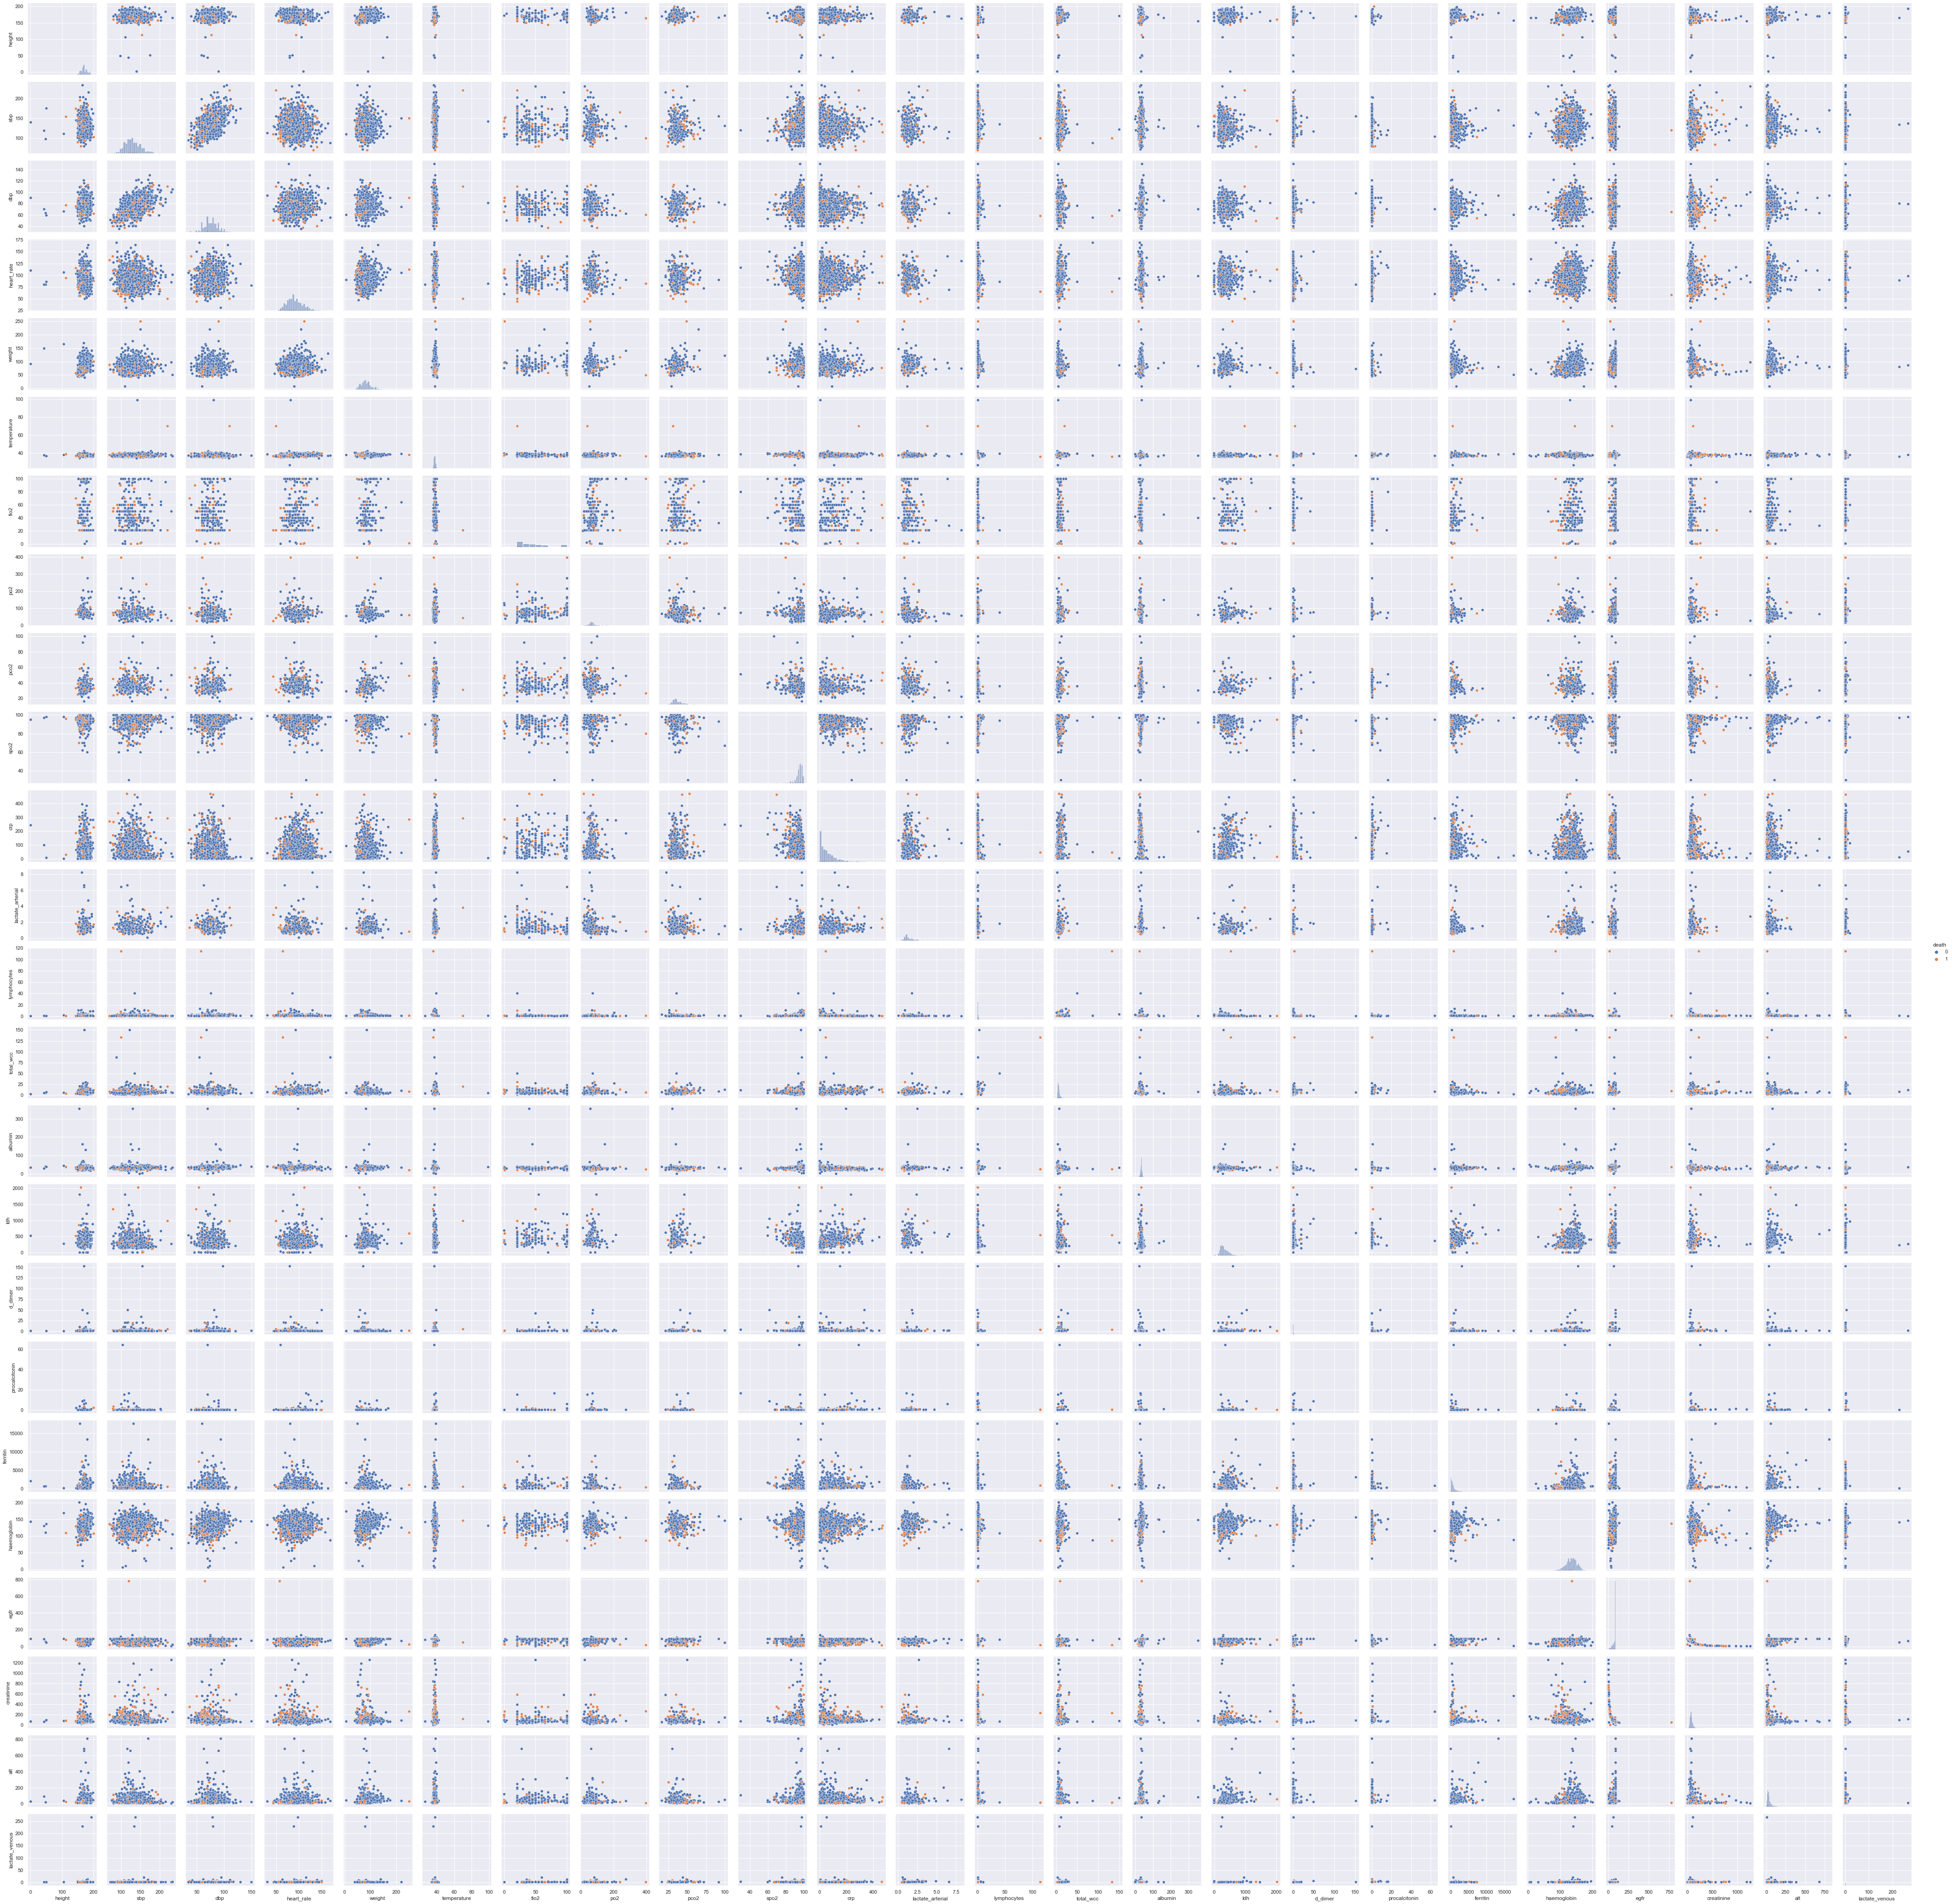

In [16]:
df_float = df_reduced[float_col + ['death']]
g = sns.PairGrid(df_float, hue="death")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

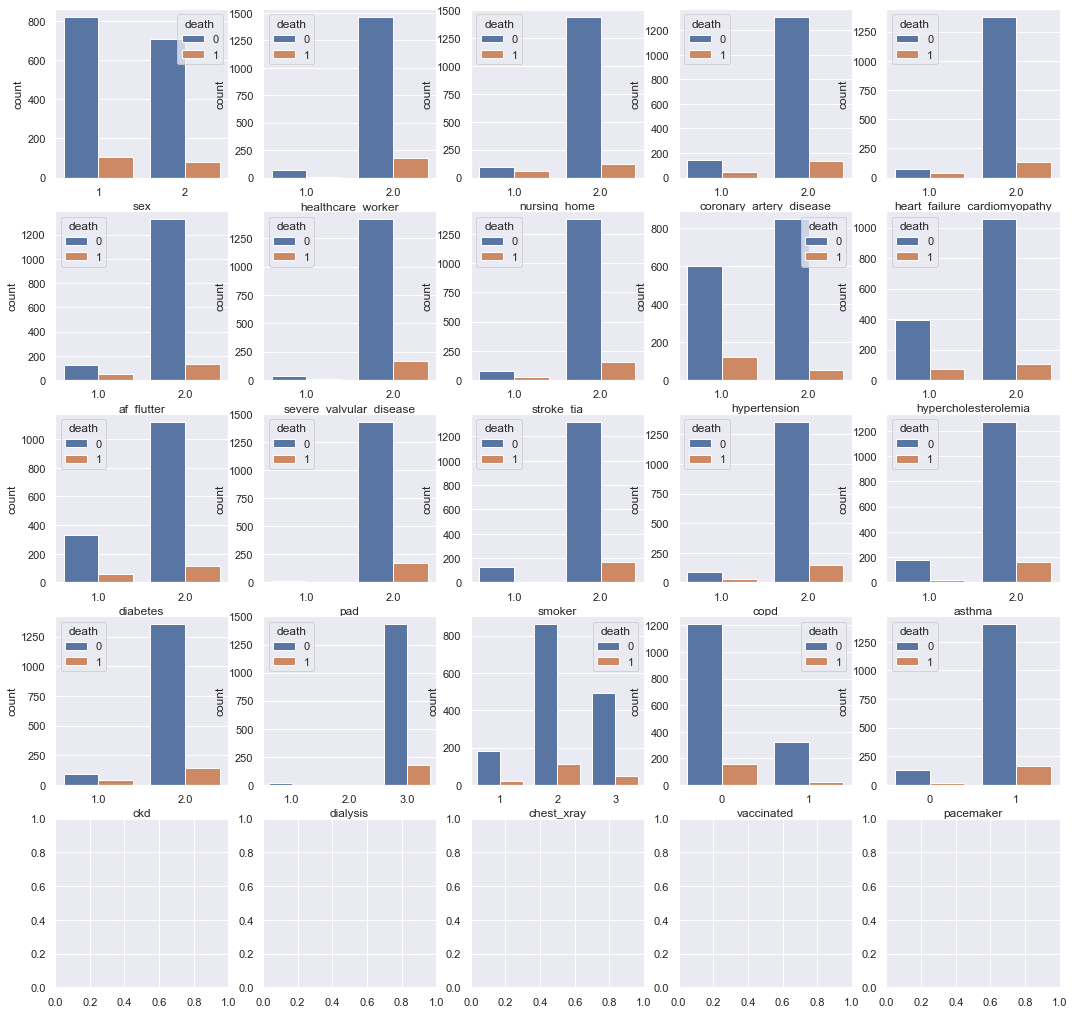

In [17]:
fig, axes = plt.subplots(5, 5, figsize=(18, 18))
i = 0
for c in categorical_col:
    sns.countplot(data=df, x=c, hue="death",ax=axes[int(i/5), i%5])
    i+=1


There are notable variables that show an increased rate of mortality

- nursing_home
- coronary_artery_disease
- heart_failure_cardiomyopathy
- af_flutter
- ppm_icd
- severe_valvular_disease
- stroke_tia
- hypertension
- hypercholesterolemia
- diabetes
- pad
- copd
- ckd
- dialysis (possibly not statistically significant)

Variables that show decreased rate of mortality:
- healthcare_worker
- smoker (possibly not statistically significant)
- vaccinated

There seems to be no significant differences of mortality across sexes.

posx and posy should be finite values
posx and posy should be finite values


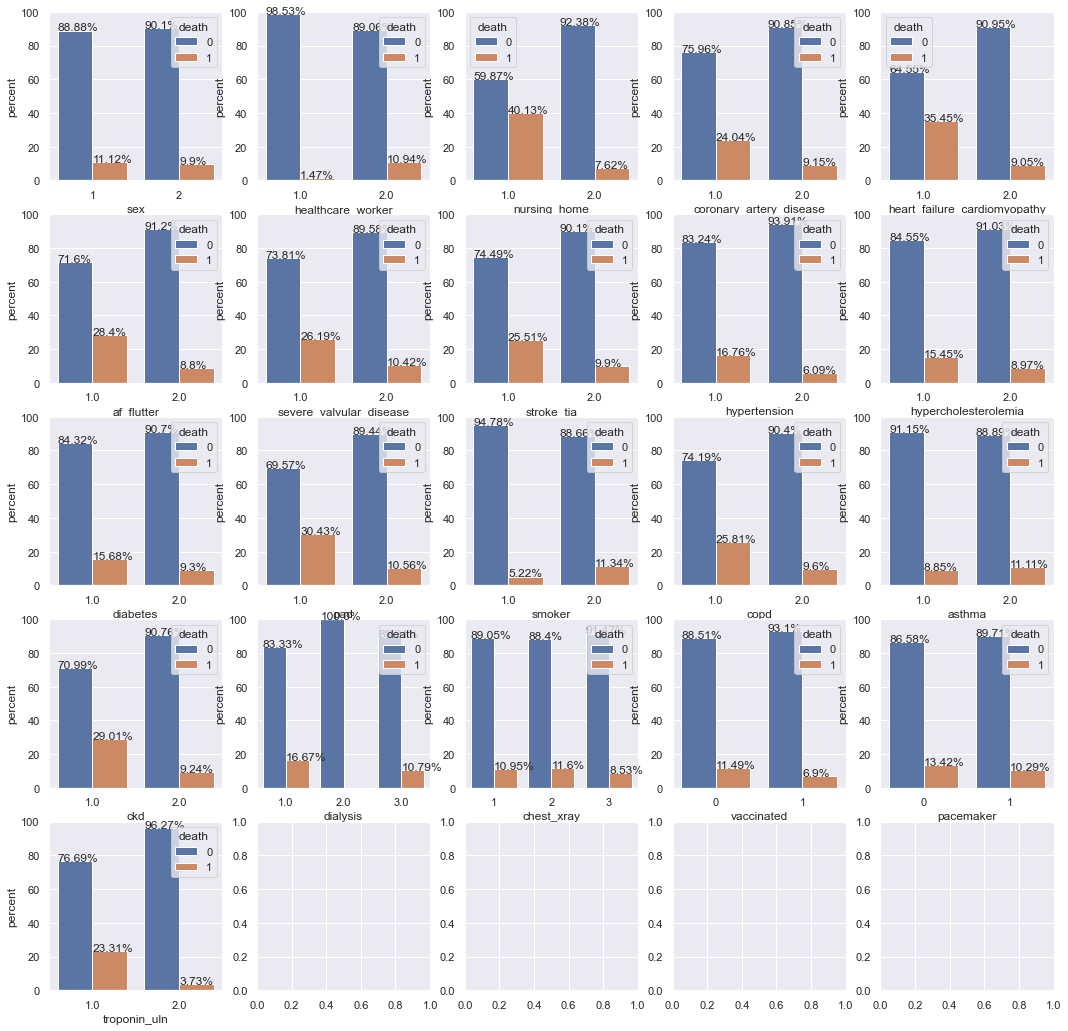

In [130]:
fig, axes = plt.subplots(5, 5, figsize=(18, 18))
i = 0
for c in categorical_col:
    x,y = c, 'death'
    df1 = df.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.barplot(x=x,y='percent',hue=y,data=df1,ax=axes[int(i/5), i%5])
    g.set_ylim(0,100)

    for p in g.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.text(txt_x,txt_y,txt)
    i+=1





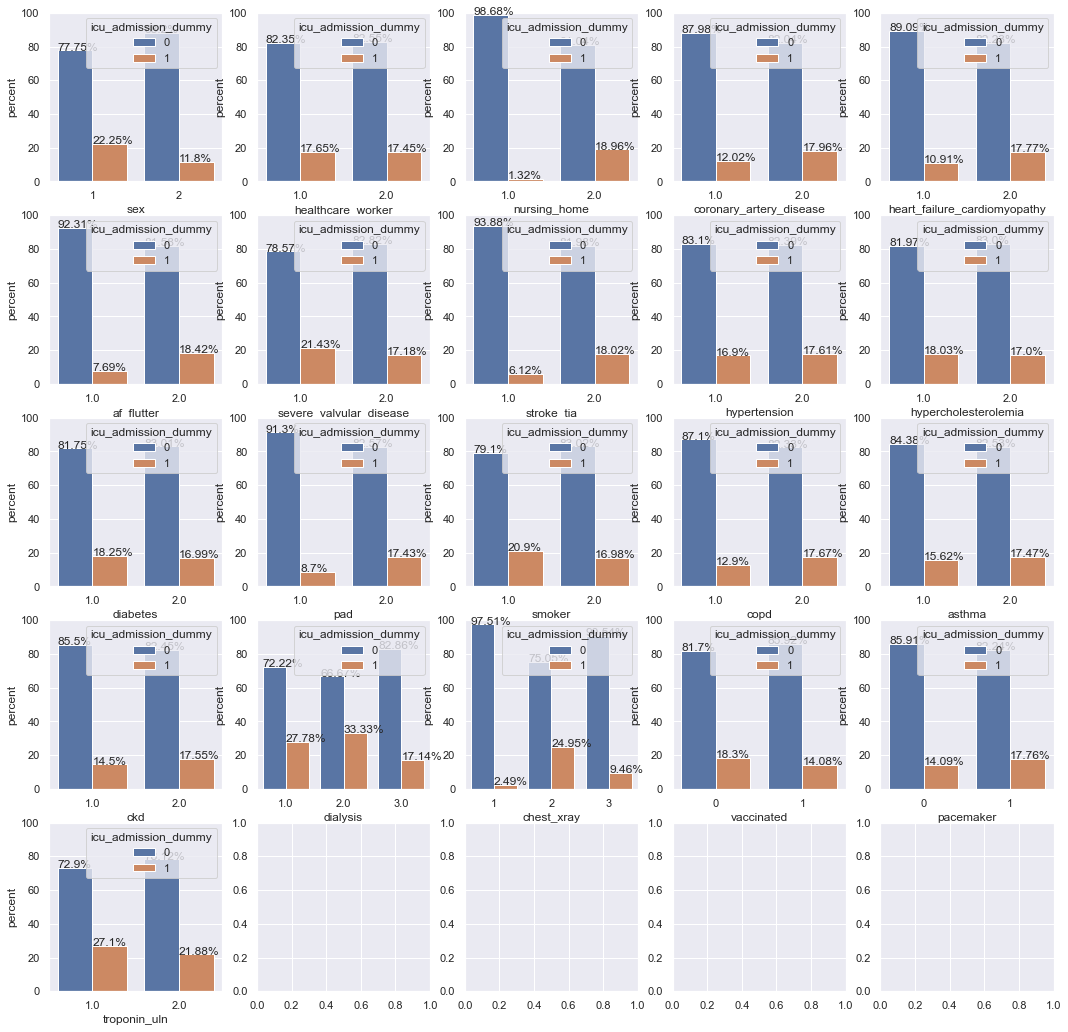

In [159]:
fig, axes = plt.subplots(5, 5, figsize=(18, 18))
i = 0
for c in categorical_col:
    x,y = c, 'icu_admission_dummy'
    df1 = df.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.barplot(x=x,y='percent',hue=y,data=df1,ax=axes[int(i/5), i%5])
    g.set_ylim(0,100)

    for p in g.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.text(txt_x,txt_y,txt)
    i+=1


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


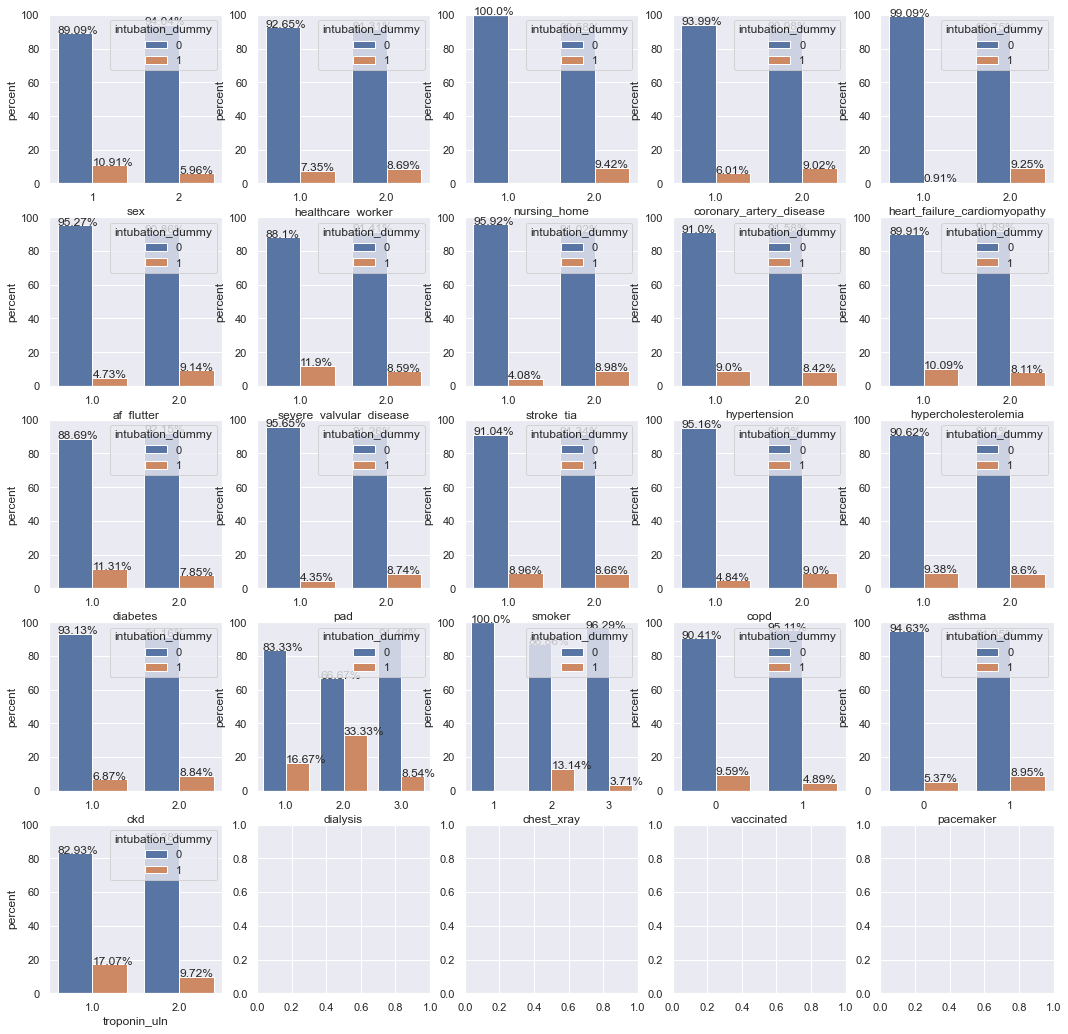

In [160]:
fig, axes = plt.subplots(5, 5, figsize=(18, 18))
i = 0
for c in categorical_col:
    x,y = c, 'intubation_dummy'
    df1 = df.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.barplot(x=x,y='percent',hue=y,data=df1,ax=axes[int(i/5), i%5])
    g.set_ylim(0,100)

    for p in g.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.text(txt_x,txt_y,txt)
    i+=1

# Preprocessing

In [193]:
df_dummy  = pd.get_dummies(df_reduced,columns = categorical_col, dummy_na=True,drop_first=True)
df_dummy.head()

# drop dummy variables that contain all 0
df_dummy = df_dummy.drop(['healthcare_worker_nan','nursing_home_nan','sex_nan',
                          'chest_xray_nan','pacemaker_nan','vaccinated_nan'],axis=1)

In [194]:
dict(df_dummy.sum())

{'age': 102892.0,
 'height': 103603.41,
 'weight': 70006.09,
 'sbp': 212709.0,
 'dbp': 118617.0,
 'heart_rate': 152292.0,
 'respiratory_rate': 37767.0,
 'temperature': 59823.41,
 'spo2': 148544.0,
 'fio2': 12771.32,
 'po2': 24212.899999999998,
 'pco2': 12296.3,
 'lactate_arterial': 488.15999999999997,
 'crp': 98657.8,
 'lymphocytes': 2076.06,
 'total_wcc': 11147.310000000001,
 'albumin': 51170.14,
 'ldh': 292127.9,
 'd_dimer': 1299.73106,
 'procalcitonin': 215.57,
 'ferritin': 719417.89,
 'haemoglobin': 217303.8,
 'egfr': 115116.4,
 'creatinine': 159083.3,
 'alt': 62120.2,
 'lactate_venous': 1711.0599999999997,
 'hs_troponin_i': 24297.0,
 'hs_troponin_t': 10933.0,
 'icu_admission_dummy': 298.0,
 'intubation_dummy': 147.0,
 'death': 180.0,
 'sex_2.0': 788.0,
 'healthcare_worker_2.0': 1644.0,
 'nursing_home_2.0': 1560.0,
 'coronary_artery_disease_2.0': 1440.0,
 'coronary_artery_disease_nan': 89.0,
 'heart_failure_cardiomyopathy_2.0': 1512.0,
 'heart_failure_cardiomyopathy_nan': 90.0,
 'a

In [195]:
n = df_dummy.shape[0]
for c in float_col:
    if sum(np.isnan(df_dummy[c])) != 0:
        col_name = c + "_nan"
        df_dummy[col_name] = np.isnan(df_dummy[c]).astype(int)

In [196]:
df_dummy.head()

age  height  weight    sbp    dbp  heart_rate  respiratory_rate  \
0   56     NaN     NaN  174.0  116.0       104.0              23.0   
1   33     NaN     NaN  116.0   66.0       102.0              26.0   
2   32     NaN     NaN  113.0   69.0       100.0              22.0   
3   92     NaN     NaN    NaN    NaN         NaN               NaN   
4   54     NaN     NaN  159.0   94.0       108.0              48.0   

   temperature  spo2  fio2  ...  d_dimer_nan  procalcitonin_nan  ferritin_nan  \
0         36.2  96.0   NaN  ...            1                  1             1   
1         37.9  91.0   NaN  ...            0                  1             1   
2         37.6  96.0   NaN  ...            1                  1             1   
3          NaN  97.0   NaN  ...            1                  1             1   
4          NaN  84.0  50.0  ...            0                  1             0   

   haemoglobin_nan  egfr_nan  creatinine_nan  alt_nan  lactate_venous_nan  \
0                0         0               0        0                   1   
1                0         0               0        0                   0   
2                0         0               0        0                   1   
3                0         0               0        1                   1   
4                0         0               0        0                   0   

   hs_troponin_i_nan  hs_troponin_t_nan  
0                  1                  1  
1                  0                  1  
2                  1                  1  
3                  1                  1  
4                  0                  1  

[5 rows x 95 columns]

In [197]:
df_dummy = df_dummy.fillna(0)

In [198]:
df_dummy.head()

age  height  weight    sbp    dbp  heart_rate  respiratory_rate  \
0   56     0.0     0.0  174.0  116.0       104.0              23.0   
1   33     0.0     0.0  116.0   66.0       102.0              26.0   
2   32     0.0     0.0  113.0   69.0       100.0              22.0   
3   92     0.0     0.0    0.0    0.0         0.0               0.0   
4   54     0.0     0.0  159.0   94.0       108.0              48.0   

   temperature  spo2  fio2  ...  d_dimer_nan  procalcitonin_nan  ferritin_nan  \
0         36.2  96.0   0.0  ...            1                  1             1   
1         37.9  91.0   0.0  ...            0                  1             1   
2         37.6  96.0   0.0  ...            1                  1             1   
3          0.0  97.0   0.0  ...            1                  1             1   
4          0.0  84.0  50.0  ...            0                  1             0   

   haemoglobin_nan  egfr_nan  creatinine_nan  alt_nan  lactate_venous_nan  \
0                0         0               0        0                   1   
1                0         0               0        0                   0   
2                0         0               0        0                   1   
3                0         0               0        1                   1   
4                0         0               0        0                   0   

   hs_troponin_i_nan  hs_troponin_t_nan  
0                  1                  1  
1                  0                  1  
2                  1                  1  
3                  1                  1  
4                  0                  1  

[5 rows x 95 columns]

In [199]:
list(df_dummy.columns.sort_values())

['af_flutter_2.0',
 'af_flutter_nan',
 'age',
 'albumin',
 'albumin_nan',
 'alt',
 'alt_nan',
 'asthma_2.0',
 'asthma_nan',
 'chest_xray_2.0',
 'chest_xray_3.0',
 'ckd_2.0',
 'ckd_nan',
 'copd_2.0',
 'copd_nan',
 'coronary_artery_disease_2.0',
 'coronary_artery_disease_nan',
 'creatinine',
 'creatinine_nan',
 'crp',
 'crp_nan',
 'd_dimer',
 'd_dimer_nan',
 'dbp',
 'dbp_nan',
 'death',
 'diabetes_2.0',
 'diabetes_nan',
 'dialysis_2.0',
 'dialysis_3.0',
 'dialysis_nan',
 'egfr',
 'egfr_nan',
 'ferritin',
 'ferritin_nan',
 'fio2',
 'fio2_nan',
 'haemoglobin',
 'haemoglobin_nan',
 'healthcare_worker_2.0',
 'heart_failure_cardiomyopathy_2.0',
 'heart_failure_cardiomyopathy_nan',
 'heart_rate',
 'heart_rate_nan',
 'height',
 'height_nan',
 'hs_troponin_i',
 'hs_troponin_i_nan',
 'hs_troponin_t',
 'hs_troponin_t_nan',
 'hypercholesterolemia_2.0',
 'hypercholesterolemia_nan',
 'hypertension_2.0',
 'hypertension_nan',
 'icu_admission_dummy',
 'intubation_dummy',
 'lactate_arterial',
 'lactate_a

# Model building

In [200]:
random_seed = 108

In [201]:
y = df_dummy['death']
X = df_dummy.drop(predictor, axis=1)


In [202]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [203]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline

In [204]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_seed,max_iter = 1000,penalty = 'none'))
#clf = LogisticRegression().fit(X_train, y_train)

pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, penalty='none',
                                    random_state=108))])

In [205]:
coefs = pipe.steps[1][1].coef_

In [206]:
coef_df = pd.DataFrame(data = {'variable' : X.columns,
                      'value' : coefs[0],
                       'mag':   abs(coefs[0])    })

In [207]:

coef_df = coef_df.sort_values('mag', ascending=False)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

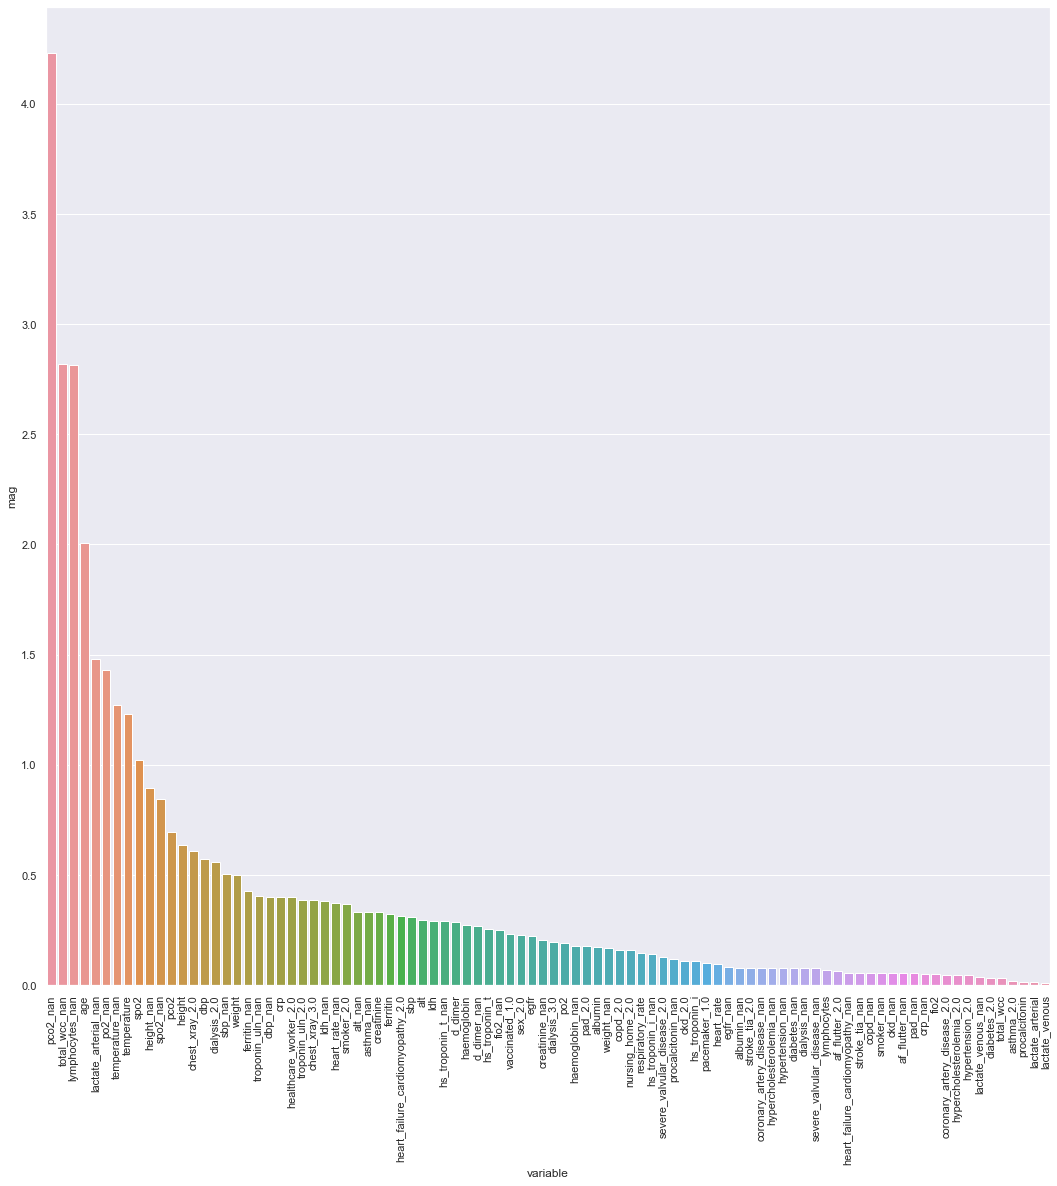

In [208]:
plt.figure(figsize=(18, 18))
sns.barplot(
    data=coef_df, x="variable", y="mag")
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=90)

In [209]:
score_dict = {'model': [],
             'accuracy':[]}

In [210]:
from sklearn.model_selection import cross_val_score
score_dict['model'].append('logistic')
score_dict['accuracy'].append(np.mean(cross_val_score(pipe, X_train, y_train, cv=10)))

In [212]:
import statsmodels.api as sm

binonmial_model = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Binomial())
res = binonmial_model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  death   No. Observations:                 1369
Model:                            GLM   Df Residuals:                     1287
Model Family:                Binomial   Df Model:                           81
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -252.87
Date:                Fri, 12 May 2023   Deviance:                       505.74
Time:                        14:30:17   Pearson chi2:                 1.08e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.2522
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                1.5497      7.260      0.213      0.831     -12.680      15.779
age                                  0.0966      0.014      7.044      0.000       0.070       0.123
height                              -0.0078      0.011     -0.710      0.478      -0.029       0.014
weight                              -0.0111      0.010     -1.169      0.243      -0.030       0.008
sbp                                 -0.0086      0.006     -1.342      0.180      -0.021       0.004
dbp                                  0.0231      0.012      1.976      0.048       0.000       0.046
heart_rate                           0.0041      0.008      0.527      0.598      -0.011       0.019
respiratory_rate                     0.0177      0.016      1.136      0.256      -0.013       0.048
temperature                         -0.1281      0.140     -0.913      0.361      -0.403       0.147
spo2                                -0.0392      0.026     -1.527      0.127      -0.090       0.011
fio2                                -0.0025      0.010     -0.258      0.796      -0.022       0.017
po2                                  0.0057      0.006      0.877      0.381      -0.007       0.018
pco2                                -0.0449      0.028     -1.621      0.105      -0.099       0.009
lactate_arterial                    -0.0183      0.370     -0.050      0.960      -0.743       0.706
crp                                  0.0057      0.002      2.819      0.005       0.002       0.010
lymphocytes                          0.0202      0.038      0.529      0.597      -0.055       0.095
total_wcc                            0.0044      0.023      0.190      0.849      -0.041       0.050
albumin                             -0.0110      0.028     -0.391      0.695      -0.066       0.044
ldh                                  0.0013      0.001      1.457      0.145      -0.000       0.003
d_dimer                             -0.1111      0.094     -1.176      0.240      -0.296       0.074
procalcitonin                        0.0210      0.171      0.123      0.902      -0.313       0.355
ferritin                            -0.0003      0.000     -1.591      0.112      -0.001    7.14e-05
haemoglobin                         -0.0081      0.007     -1.177      0.239      -0.022       0.005
egfr                                 0.0065      0.005      1.177      0.239      -0.004       0.017
creatinine                           0.0037      0.002      2.335      0.020       0.001       0.007
alt                                 -0.0056      0.004     -1.318      0.188      -0.014       0.003
lactate_venous                       0.0012      0.025      0.048      0.962      -0.048       0.051
hs_troponin_i                        0.0007      0.00

In [213]:
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l2'],
         'C': np.logspace(1e-2,1e2,num=10)}

grid = GridSearchCV(LogisticRegression(random_state=random_seed,max_iter = 1000,solver = 'lbfgs',n_jobs=4),
                    param_grid = params,cv=5)

In [214]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
grid.fit(X_train_scaled,y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, n_jobs=4,
                                          random_state=108),
             param_grid={'C': array([1.02329299e+000, 1.31825674e+011, 1.69824365e+022, 2.18776162e+033,
       2.81838293e+044, 3.63078055e+055, 4.67735141e+066, 6.02559586e+077,
       7.76247117e+088, 1.00000000e+100]),
                         'penalty': ['l2']})

In [215]:
print(grid.best_params_)

score_dict['model'].append('l2')
score_dict['accuracy'].append(np.mean(cross_val_score(grid.best_estimator_, X_train, y_train, cv=10)))

{'C': 1.023292992280754, 'penalty': 'l2'}


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

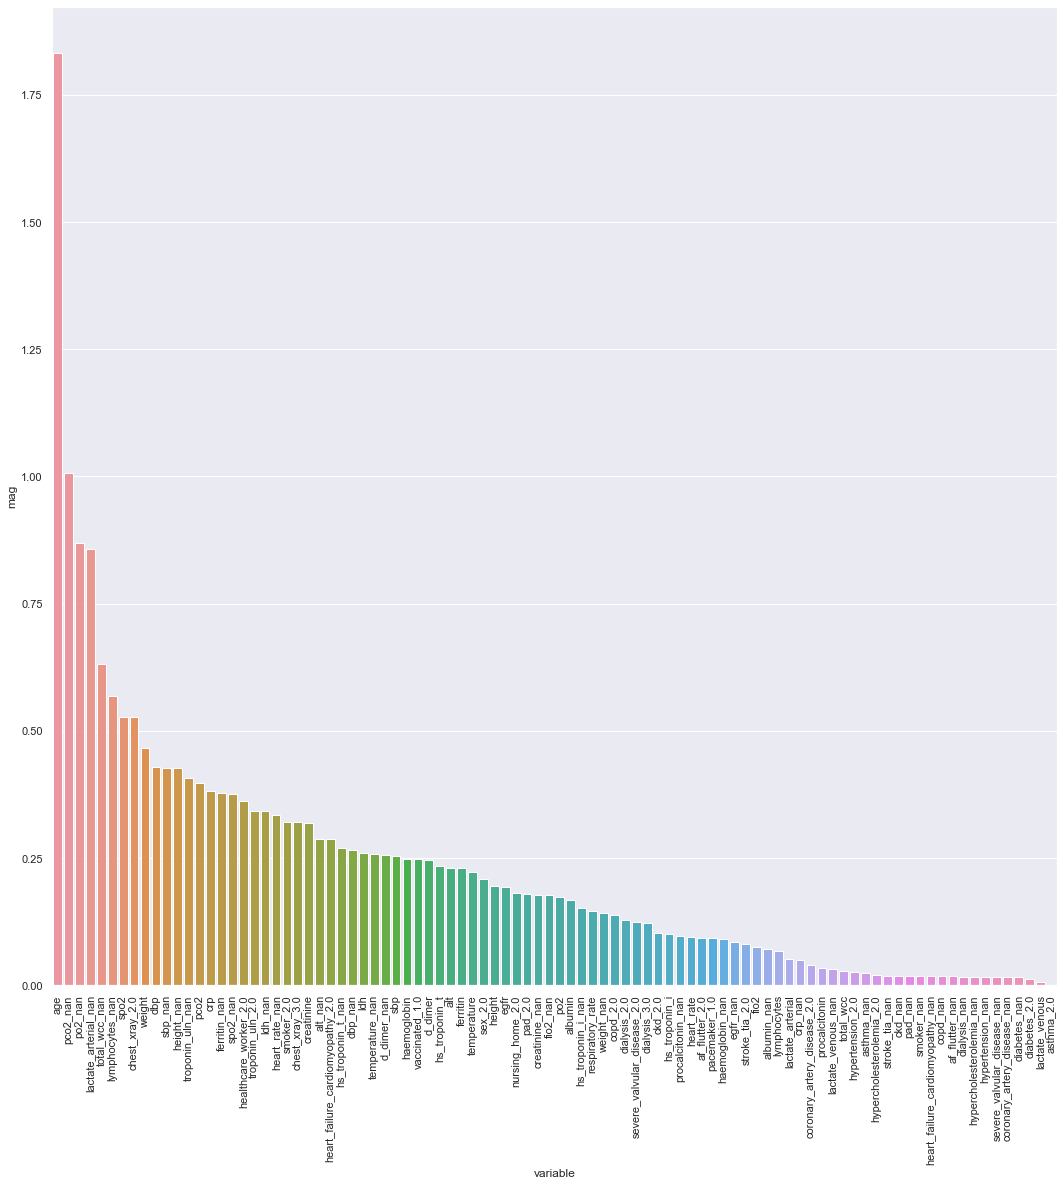

In [216]:
coefs = grid.best_estimator_.coef_
l2_coef_df = pd.DataFrame(data = {'variable' : X.columns,
                      'value' : coefs[0],
                       'mag':   abs(coefs[0])    })
l2_coef_df = l2_coef_df.sort_values('mag', ascending=False)
plt.figure(figsize=(18, 18))
sns.barplot(
    data=l2_coef_df, x="variable", y="mag")
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=90)

In [217]:
l1_params = {'penalty': ['l1'],
         'C': np.logspace(1e-2,1e2,num=10)}

l1_grid = GridSearchCV(LogisticRegression(random_state=random_seed,max_iter = 100,solver = 'saga',n_jobs=4),
                    param_grid = l1_params,cv=5)
l1_grid.fit(X_train_scaled,y_train)

D:\Program Files\anacondav2\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=4, random_state=108,
                                          solver='saga'),
             param_grid={'C': array([1.02329299e+000, 1.31825674e+011, 1.69824365e+022, 2.18776162e+033,
       2.81838293e+044, 3.63078055e+055, 4.67735141e+066, 6.02559586e+077,
       7.76247117e+088, 1.00000000e+100]),
                         'penalty': ['l1']})

In [218]:
print(l1_grid.best_params_)
score_dict['model'].append('l1')
score_dict['accuracy'].append(np.mean(cross_val_score(l1_grid.best_estimator_, X_train, y_train, cv=10)))


{'C': 1.023292992280754, 'penalty': 'l1'}


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

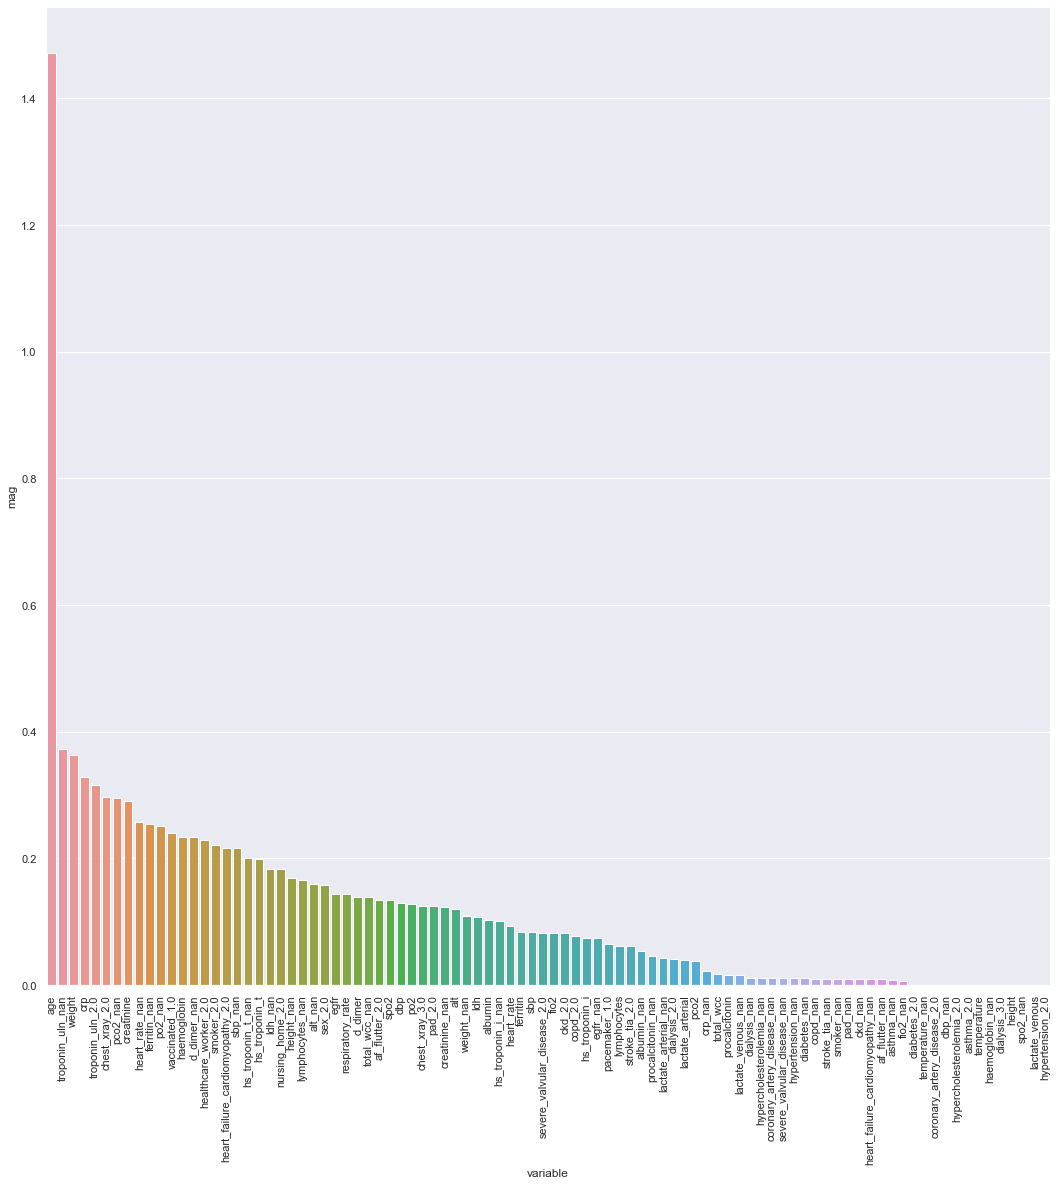

In [219]:
coefs = l1_grid.best_estimator_.coef_
l1_coef_df = pd.DataFrame(data = {'variable' : X.columns,
                      'value' : coefs[0],
                       'mag':   abs(coefs[0])    })
l1_coef_df = l1_coef_df.sort_values('mag', ascending=False)
plt.figure(figsize=(18, 18))
sns.barplot(
    data=l1_coef_df, x="variable", y="mag")
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=90)

In [220]:
elastic_params = {
         'l1_ratio': np.linspace(0,1,num=10)}

elastic_grid = GridSearchCV(
        LogisticRegression(
            random_state=random_seed,
            max_iter = 1000,
            solver = 'saga',
           penalty = 'elasticnet',
            C = 1.023292992280754,
            n_jobs=4),
        param_grid = elastic_params,cv=5)
elastic_grid.fit(X_train_scaled,y_train)

D:\Program Files\anacondav2\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(C=1.023292992280754, max_iter=1000,
                                          n_jobs=4, penalty='elasticnet',
                                          random_state=108, solver='saga'),
             param_grid={'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])})

In [221]:
print(elastic_grid.best_params_)
score_dict['model'].append('elasticnet')
score_dict['accuracy'].append(np.mean(cross_val_score(elastic_grid.best_estimator_, X_train, y_train, cv=10)))


{'l1_ratio': 1.0}


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

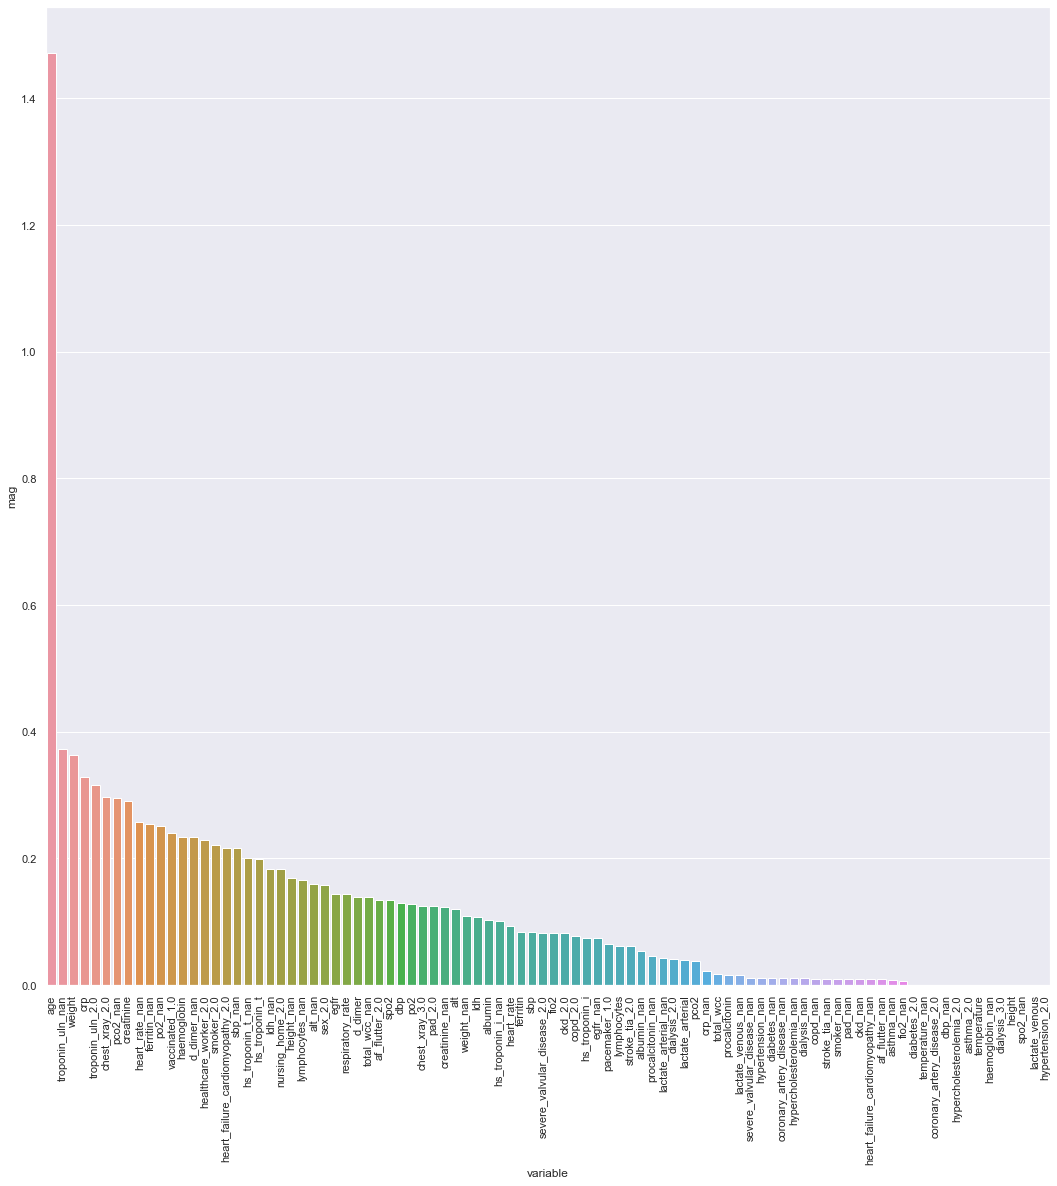

In [222]:
coefs = elastic_grid.best_estimator_.coef_
elastic_coef_df = pd.DataFrame(data = {'variable' : X.columns,
                      'value' : coefs[0],
                       'mag':   abs(coefs[0])    })
elastic_coef_df = l1_coef_df.sort_values('mag', ascending=False)
plt.figure(figsize=(18, 18))
sns.barplot(
    data=elastic_coef_df, x="variable", y="mag")
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=90)

### Trees

In [223]:
from sklearn.tree import DecisionTreeClassifier

In [224]:
tree_params = {
    'criterion':['gini', 'entropy'],
    'min_samples_split':np.linspace(0.02,0.3,num=10) 
    
}
tree = DecisionTreeClassifier(random_state = random_seed)
tree_grid = GridSearchCV(tree,param_grid = tree_params,cv=5)
tree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=108),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': array([0.02      , 0.05111111, 0.08222222, 0.11333333, 0.14444444,
       0.17555556, 0.20666667, 0.23777778, 0.26888889, 0.3       ])})

In [225]:
print(tree_grid.best_params_)
score_dict['model'].append('tree')
score_dict['accuracy'].append(np.mean(cross_val_score(tree_grid.best_estimator_, X_train, y_train, cv=10)))


{'criterion': 'entropy', 'min_samples_split': 0.17555555555555552}


[Text(0.6363636363636364, 0.9285714285714286, 'X[0] <= 69.5\nentropy = 0.476\nsamples = 1369\nvalue = [1229, 140]'),
 Text(0.45454545454545453, 0.7857142857142857, 'X[23] <= 133.5\nentropy = 0.135\nsamples = 849\nvalue = [833, 16]'),
 Text(0.36363636363636365, 0.6428571428571429, 'X[17] <= 0.6\nentropy = 0.08\nsamples = 812\nvalue = [804, 8]'),
 Text(0.2727272727272727, 0.5, 'X[15] <= 7.785\nentropy = 0.149\nsamples = 376\nvalue = [368, 8]'),
 Text(0.18181818181818182, 0.35714285714285715, 'X[6] <= 25.5\nentropy = 0.06\nsamples = 284\nvalue = [282, 2]'),
 Text(0.09090909090909091, 0.21428571428571427, 'entropy = 0.0\nsamples = 234\nvalue = [234, 0]'),
 Text(0.2727272727272727, 0.21428571428571427, 'entropy = 0.242\nsamples = 50\nvalue = [48, 2]'),
 Text(0.36363636363636365, 0.35714285714285715, 'entropy = 0.348\nsamples = 92\nvalue = [86, 6]'),
 Text(0.45454545454545453, 0.5, 'entropy = 0.0\nsamples = 436\nvalue = [436, 0]'),
 Text(0.5454545454545454, 0.6428571428571429, 'entropy = 0.7

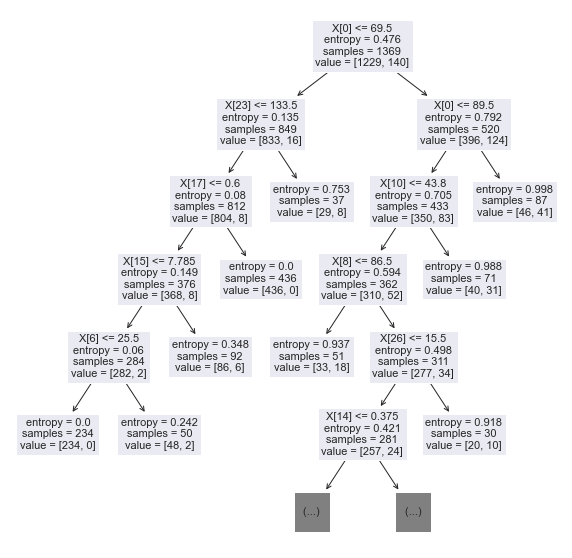

In [226]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 10))
plot_tree(tree_grid.best_estimator_,max_depth = 5)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

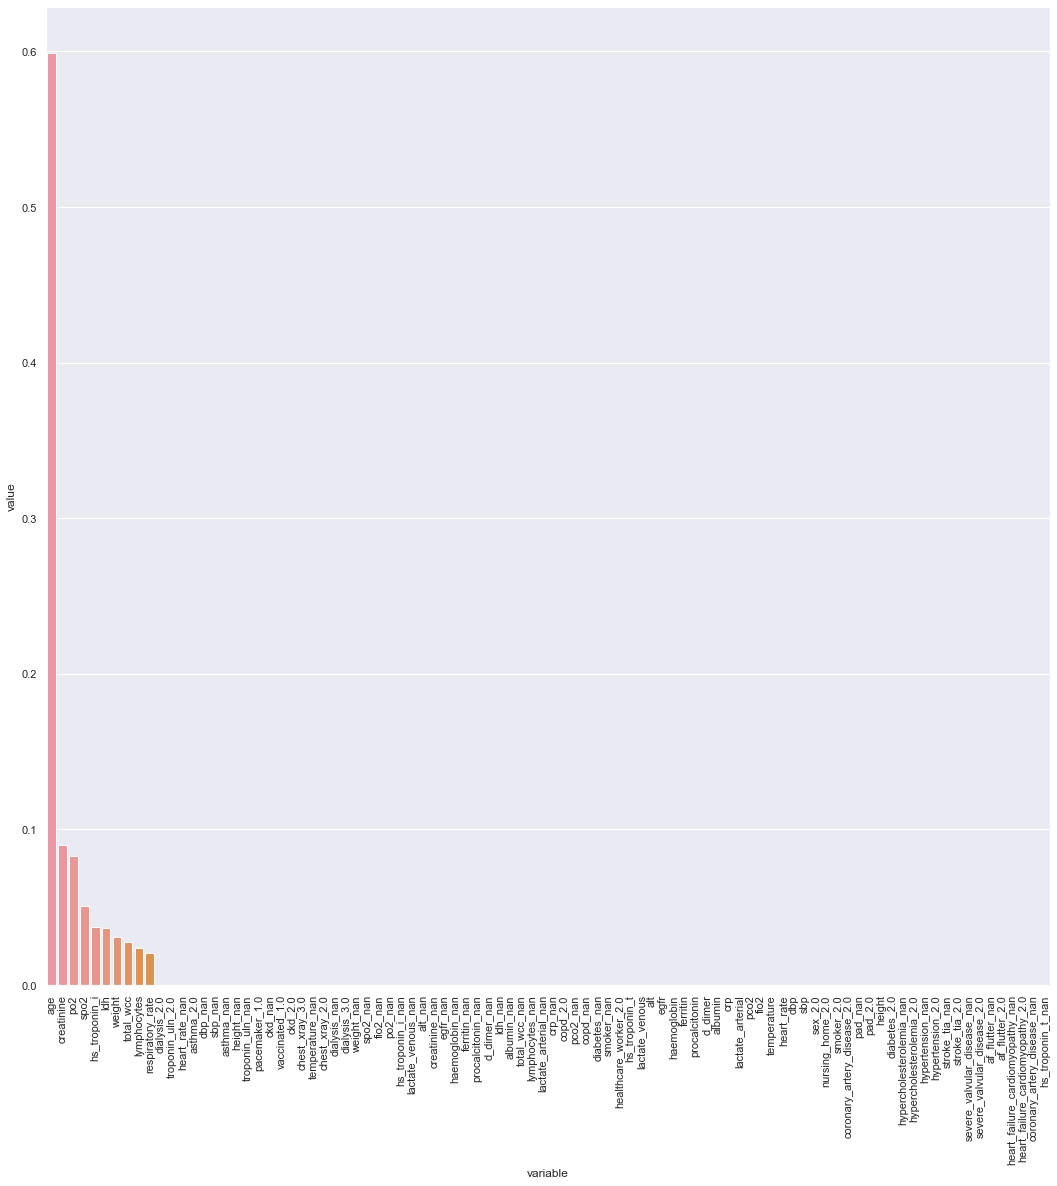

In [227]:
coefs = tree_grid.best_estimator_.feature_importances_
tree_coef_df = pd.DataFrame(data = {'variable' : X.columns,
                      'value' : coefs })
tree_coef_df = tree_coef_df.sort_values('value', ascending=False)
plt.figure(figsize=(18, 18))
sns.barplot(
    data=tree_coef_df, x="variable", y="value")
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation=90)



In [228]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_features = 'sqrt',random_state = random_seed,n_estimators=100)
rf_grid = GridSearchCV(rf,param_grid = tree_params,cv=5)
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              random_state=108),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': array([0.02      , 0.05111111, 0.08222222, 0.11333333, 0.14444444,
       0.17555556, 0.20666667, 0.23777778, 0.26888889, 0.3       ])})

In [229]:
importances = rf_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_grid.best_estimator_.estimators_], axis=0)


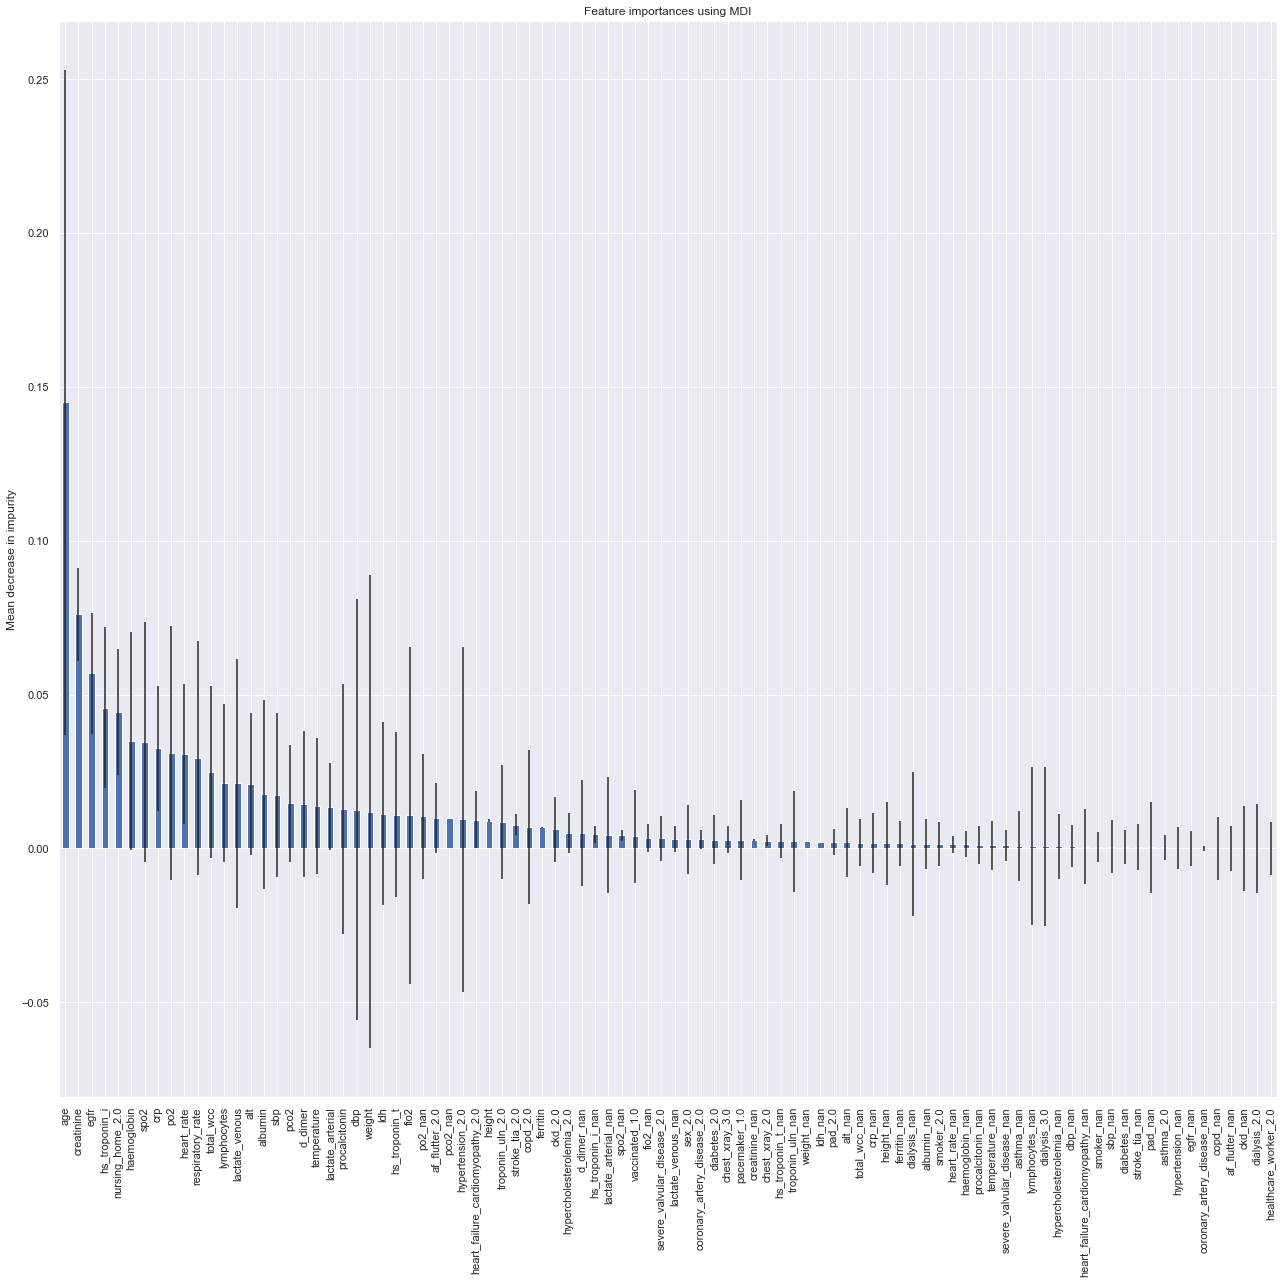

In [230]:

forest_importances = pd.Series(importances, index= X.columns)
forest_importances = forest_importances.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(18, 18))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [231]:
print(rf_grid.best_params_)
score_dict['model'].append('random_forest')
score_dict['accuracy'].append(np.mean(cross_val_score(rf_grid.best_estimator_, X_train, y_train, cv=10)))

{'criterion': 'gini', 'min_samples_split': 0.02}


In [232]:
pd.DataFrame(score_dict).sort_values('accuracy',ascending=False)

model  accuracy
5  random_forest  0.898465
4           tree  0.897735
2             l1  0.896275
0       logistic  0.895561
1             l2  0.893350
3     elasticnet  0.892609